In [ ]:
!pip install stopwords

import pandas, warnings, stopwords

from tensorflow.keras import models, layers, callbacks

warnings.filterwarnings("ignore")

In [2]:
sarcasm = pandas.read_json("sarcasm.json")

sarcasm.columns.tolist()

['article_link', 'headline', 'is_sarcastic']

In [3]:
sarcasm = sarcasm.iloc[:, 1:]

sarcasm.columns.tolist()

['headline', 'is_sarcastic']

In [4]:
sarcasm.iloc[:5]

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
sarcasm.tail()

,headline,is_sarcastic
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0
26708,gourmet gifts for the foodie 2014,0


In [6]:
null = sarcasm.isnull().sum()

null.sum()

0

In [7]:
len(sarcasm.iloc[0, 0].split())

12

In [8]:
def HelperClear(sentences):
  """
  Helper to Clear Your Sentences
  """
  output = sentences.lower().split()
  unlist = stopwords.get_stopwords("english")
  output = [i for i in output if i not in unlist]
  result = " ".join(output)
  return result

sarcasm.headline = sarcasm.headline.apply(HelperClear)

len(sarcasm.iloc[0, 0].split())

10

In [9]:
from sklearn.model_selection import train_test_split

test_split = 0.15

train, test = train_test_split(sarcasm, test_size=test_split)

train.shape

(22702, 2)

In [10]:
test.shape

(4007, 2)

In [11]:
class EarlyFinish(callbacks.Callback):
  """
  80 Early Callback
  """
  def on_epoch_end(self, epochs, logs={}):
    if logs.get("accuracy") >= 0.80 and logs.get("val_accuracy") >= 0.80:
      self.model.stop_training = True

EarlyFinish = EarlyFinish()

In [12]:
token_limit = 10000; outlen = 50

tokener = layers.TextVectorization(
  # Total Token
  max_tokens=token_limit,
  # Output Sequence Length
  output_sequence_length=outlen,
)

tokener.adapt(train.headline)

len(tokener.get_vocabulary())

10000

In [13]:
import numpy as np

train_input = np.array(tokener(train.headline))

train_label = np.array(train.is_sarcastic)

In [14]:
test_input = np.array(tokener(test.headline))

test_label = np.array(test.is_sarcastic)

In [15]:
import warnings

warnings.filterwarnings("ignore")

model = models.Sequential([
  layers.Embedding(token_limit, 16, input_length=outlen),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dense(24, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

hist = model.fit(train_input, train_label, epochs=15, validation_data=(test_input, test_label), callbacks=[EarlyFinish])

In [17]:
model.evaluate(train_input, train_label, verbose=False)

[0.3545589745044708, 0.8608052134513855]

In [18]:
model.evaluate(test_input, test_label, verbose=False)

[0.4251443147659302, 0.8058397769927979]

In [19]:
import os, urllib

if not os.path.exists("Helplot.py"):

  giturl = "https://raw.githubusercontent.com/Kelniit/Hut/refs/heads/main/Helplot.py"

  urllib.request.urlretrieve(giturl, "Helplot.py")

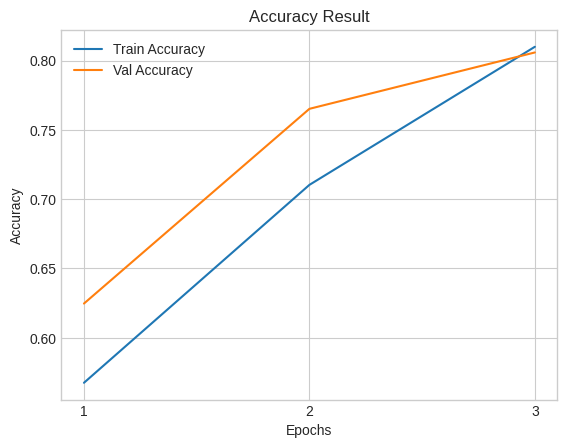

In [20]:
from Helplot import Helplot

plot_hist = Helplot(hist)

plot_hist.Relplot

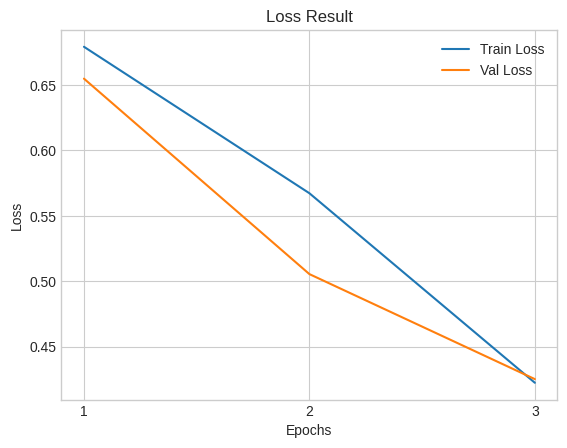

In [21]:
plot_hist.Falplot

In [22]:
if not os.path.exists("Confuplot.py"):

  giturl = "https://raw.githubusercontent.com/Kelniit/Halte/refs/heads/main/Confuplot.py"

  urllib.request.urlretrieve(giturl, "Confuplot.py")

logits = model.predict(test_input, verbose=False)

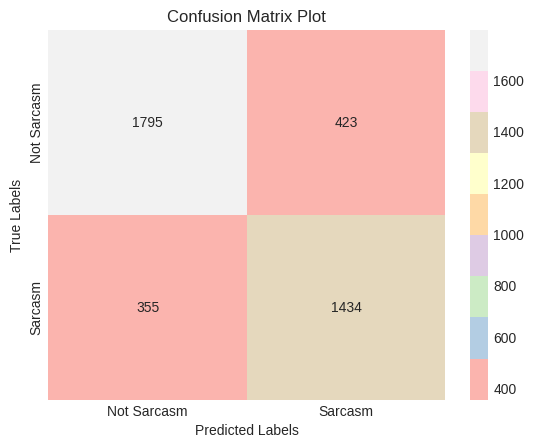

In [23]:
from Confuplot import ConfusionMatrixHelplot

logits = np.round(logits)

classes = ["Not Sarcasm", "Sarcasm"]

ConfusionMatrixHelplot(test_label, logits, classes)

In [ ]:
tester = test_input[:50]

ModelFolder = "/content/Modelite"

model.export(ModelFolder)

In [25]:
import tensorflow as tf

import pathlib

tflite = tf.lite.TFLiteConverter

tflite_model = tflite.from_saved_model(ModelFolder)

tflite_model.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = tflite_model.convert()

pathfile = "Halte.tflite"

tflite_model_file = pathlib.Path(pathfile)

tflite_model_file.write_bytes(tflite_model)

165032

In [26]:
os.path.getsize(pathfile) / float(2**20)

0.15738677978515625

In [27]:
interpreter = tf.lite.Interpreter(model_path=pathfile)

interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor'], 'outputs': ['output_0']}}

In [28]:
lite_interpreter = interpreter.get_signature_runner('serving_default')

lite_interpreter

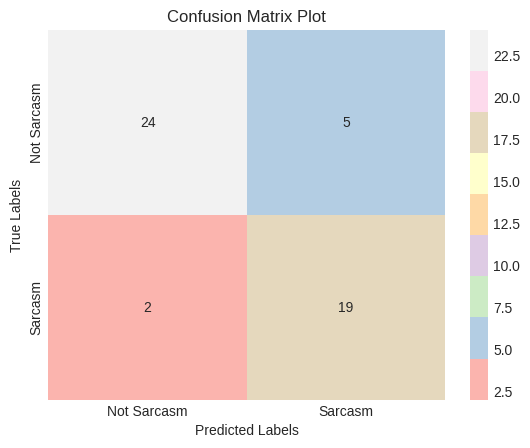

In [29]:
testa = lite_interpreter(keras_tensor=tester.astype(np.float32))['output_0']

testa = np.round(testa)

testa_label = test_label[:50]

ConfusionMatrixHelplot(testa_label, testa, classes)